In [46]:
!pip install pandas numpy seaborn matplotlib scikit-learn catboost xgboost lightgbm optuna 

In [47]:
from typing import List, Tuple

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_percentage_error,
                             root_mean_squared_error, r2_score,
                             silhouette_score, rand_score,
                             davies_bouldin_score)
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder,
                                   LabelBinarizer, StandardScaler)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgbm

import optuna

from copy import deepcopy

In [48]:
df = pd.read_csv("./ds_salaries.csv")

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [50]:
def find_err(df: pd.DataFrame) -> List[str]:
    unexp = []

    expected_values = {
        'experience_level': ['SE', 'MI', 'EN', 'EX'],
        'employment_type': ['FT', 'PT', 'CT', 'FL'],
        'company_size': ['S', 'M', 'L']
    }

    for column in df.select_dtypes(include="object").columns:
        if column in expected_values:
            uniques = df[column].unique()
            result = set(uniques) - set(expected_values[column])

            if result:
                unexp.append(f"В столбце '{column}' найдены неожиданные значения: {result}")
        else:
            return ["Все значения в порядке."]

In [51]:
print(find_err(df))

['Все значения в порядке.']


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


`Судя по всему все типы правильные, а так же нет нанов`

In [53]:
def IQR(df: pd.DataFrame, cols: List[str]) -> List[str]:

  result = {}

  for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].tolist()

    result[col] = outliers

  length = max(len(v) for v in result.values())

  for k in result:
    result[k] += [np.nan] * (length - len(result[k]))

  return pd.DataFrame(result)

In [54]:
outlies = IQR(df, df.select_dtypes(exclude="object").columns)

In [55]:
outlies.count()

work_year         76
salary           113
salary_in_usd     63
remote_ratio       0
dtype: int64

`Судя по всему больше всего выбросов в зарплате`

In [56]:
(outlies.count() / df.shape[0]) * 100

work_year        2.023968
salary           3.009321
salary_in_usd    1.677763
remote_ratio     0.000000
dtype: float64

`Выбросы объясняются тем что есть разные валюты, а значит разные страны и это уже может быть следствием выбросов в долларх, особенно если страны распределены неравномерно, так же замечу, что выбросов не более трёх процентов, кажется от них можно избавиться вряд ли мы сильно испортим реальное распределение`

`Зарплата в долларах к тому же это целевая переменная`

In [57]:
df["salary_currency"].unique()

array(['EUR', 'USD', 'INR', 'HKD', 'CHF', 'GBP', 'AUD', 'SGD', 'CAD',
       'ILS', 'BRL', 'THB', 'PLN', 'HUF', 'CZK', 'DKK', 'JPY', 'MXN',
       'TRY', 'CLP'], dtype=object)

`Их тут действительно много, посмотрим на то как они распределены`

/tmp/ipykernel_499841/3755800608.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='salary_currency',


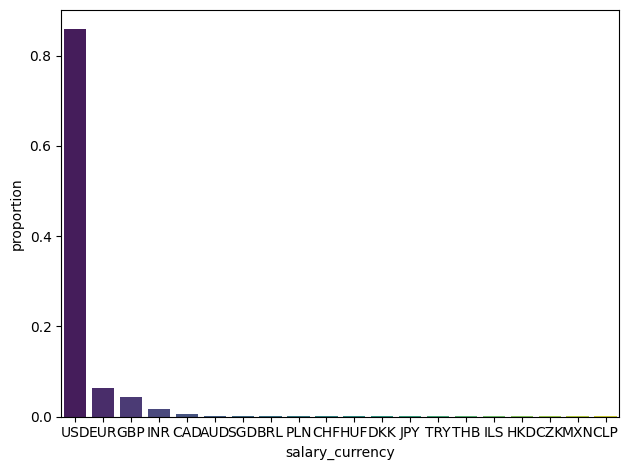

In [58]:
sns.barplot(x='salary_currency',
            y='proportion',
            data=df["salary_currency"].value_counts(normalize=True).reset_index(),
            palette='viridis')

plt.tight_layout()
plt.show()

In [59]:
counts = list(df[df.select_dtypes(include="object").columns].nunique().items())
counts

[('experience_level', 4),
 ('employment_type', 4),
 ('job_title', 93),
 ('salary_currency', 20),
 ('employee_residence', 78),
 ('company_location', 72),
 ('company_size', 3)]

`Всё соответствует рабочей тематике, всё оставляем, за много категорий примем те категориальные признаки в которых больше 20 категорий, названия полезной информации не несут, местоположение сильно усложнит данные`

In [60]:
def many_cats(counts: List[Tuple[str, int]]) -> List[str]:
    result = []

    for i in counts:
        if i[1] >= 21:
            result.append(i[0])

    return result

In [61]:
m_cats = many_cats(counts)
m_cats

['job_title', 'employee_residence', 'company_location']

In [62]:
X = df.drop("salary_in_usd", axis=1)
y = df["salary_in_usd"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Непрерывные признаки

In [64]:
X_cont = df.drop(df.select_dtypes(include="object").columns.tolist() + ["salary_in_usd"], axis=1)
y_cont = deepcopy(y)

X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(X_cont, y_cont,
                                             test_size=0.2, random_state=42)

In [65]:
X_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   work_year     3755 non-null   int64
 1   salary        3755 non-null   int64
 2   remote_ratio  3755 non-null   int64
dtypes: int64(3)
memory usage: 88.1 KB


#### Все признаки

In [79]:
cats = df.select_dtypes(include="object").columns

X_cats = X.drop(["job_title", "employee_residence"], axis=1)
y_cats = deepcopy(y)

X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(X_cats, y_cats,
                                             test_size=0.2, random_state=42)

In [80]:
X_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         3755 non-null   int64 
 1   experience_level  3755 non-null   object
 2   employment_type   3755 non-null   object
 3   salary            3755 non-null   int64 
 4   salary_currency   3755 non-null   object
 5   remote_ratio      3755 non-null   int64 
 6   company_location  3755 non-null   object
 7   company_size      3755 non-null   object
dtypes: int64(3), object(5)
memory usage: 234.8+ KB


In [81]:
lr_cont = LinearRegression()

lr_cont.fit(X_train_cont, y_train_cont)

predict_cont = lr_cont.predict(X_test_cont)

mape_cont = mean_absolute_percentage_error(y_test_cont, predict_cont)
rmse_cont = root_mean_squared_error(y_test_cont, predict_cont)

print("MAPE: ", mape_cont, "RMSE: ", rmse_cont)

MAPE:  0.7062831670023226 RMSE:  61363.88765386044


`Качество модели оставляет желать лучшего судя по MAPE 70% случаев мы ошибаемся. Судя по RMSE мы ошибаемся на 63к долларов, не очень приемлемо`

In [82]:
lgbm_train = lgbm.Dataset(X_train_cont, y_train_cont)
lgbm_test = lgbm.Dataset(X_test_cont, y_test_cont)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
}


lgbm_model_rmse = lgbm.train(params=params, train_set=lgbm_train)
lgbm_pred = lgbm_model_rmse.predict(X_test_cont)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 3
[LightGBM] [Info] Start training from score 138055.989348


In [83]:
lgbm_mape_cont = mean_absolute_percentage_error(y_test_cont, lgbm_pred)
lgbm_rmse_count = root_mean_squared_error(y_test_cont, lgbm_pred)
print("MAPE: ", lgbm_mape_cont, "RMSE: ", lgbm_rmse_count)

MAPE:  0.2648598856417647 RMSE:  20245.94788723197


`Качество модели улучшилось`

#### OHE prepare

In [71]:
X_train_to_enc = X_train_cats[[i for i in cats if i not in ['job_title', 'employee_residence']]]
X_test_to_enc = X_test_cats[[i for i in cats if i not in ['job_title', 'employee_residence']]]

In [72]:
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
one_hot_encoded_tr = ohe.fit_transform(X_train_to_enc)
ohe_output_df_train = pd.DataFrame(one_hot_encoded_tr, columns=ohe.get_feature_names_out(), index=X_train_to_enc.index)
X_train_ohe = pd.concat([X_train_cont, ohe_output_df_train], axis=1)

In [85]:
X_train_ohe

,work_year,salary,remote_ratio,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,salary_currency_BRL,...,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
2238,2022,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
485,2023,151800,100,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2177,2022,100000,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3305,2022,156600,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1769,2023,175000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,2023,150000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1294,2023,180180,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
860,2023,310000,100,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3507,2021,53000,50,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [86]:
one_hot_encoded_ts = ohe.transform(X_test_to_enc)
ohe_output_df_test = pd.DataFrame(one_hot_encoded_ts, columns=ohe.get_feature_names_out(), index=X_test_to_enc.index)
X_test_ohe = pd.concat([X_test_cont, ohe_output_df_test], axis=1)

/home/nikifor/Desktop/boostings/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [87]:
X_test_ohe

,work_year,salary,remote_ratio,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,salary_currency_BRL,...,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
2148,2022,168000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1044,2023,179975,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3321,2022,144000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
439,2023,222200,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3519,2021,230000,50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,2022,105000,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2897,2022,141525,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
612,2023,58000,100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2677,2022,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Linear Regression

In [88]:
lr_ohe = LinearRegression()

lr_ohe.fit(X_train_ohe, y_train_cats)

lr_ohe_pred = lr_ohe.predict(X_test_ohe)

lr_ohe_rmse = root_mean_squared_error(y_test_cats, lr_ohe_pred)
lr_ohe_mape = mean_absolute_percentage_error(y_test_cats, lr_ohe_pred)

##### XGBoosting

In [89]:
xgb_ohe = xgb.XGBRegressor()

xgb_ohe.fit(X_train_ohe, y_train_cats)

xgb_ohe_pred = xgb_ohe.predict(X_test_ohe)

xgb_ohe_rmse = root_mean_squared_error(y_test_cats, xgb_ohe_pred)
xgb_ohe_mape = mean_absolute_percentage_error(y_test_cats, xgb_ohe_pred)

In [90]:
print(f"LR RMSE: {lr_ohe_rmse} LR MAPE: {lr_ohe_mape}\nXGB RMSE: {xgb_ohe_rmse} XGB MAPE: {xgb_ohe_mape}")

LR RMSE: 50508.58315947336 LR MAPE: 0.5037539947931781
XGB RMSE: 6430.75244140625 XGB MAPE: 0.02387440763413906


`XGB справился намного лучше, нежели линейная регрессия, что очевидно`

#### LabelEncoding

In [91]:
def lable_enc(df_cats_tr: pd.DataFrame, df_cont_tr: pd.DataFrame,
              df_cats_ts: pd.DataFrame, df_cont_ts: pd.DataFrame) -> Tuple[pd.DataFrame]:

  df_cats_tr_a = {}
  df_cats_ts_a = {}

  for i, j in enumerate(df_cats_tr.columns):

    le = LabelEncoder()
    df_cats_tr_a[j] = le.fit_transform(df_cats_tr[j])

    df_cats_ts[j] = df_cats_ts[j].map(lambda x: 0 if x not in le.classes_ else x)
    le.classes_ = np.append(le.classes_, 0)

    df_cats_ts_a[j] = le.transform(df_cats_ts[j])

  df_cats_tr_d = pd.DataFrame(df_cats_tr_a)
  df_cats_ts_d = pd.DataFrame(df_cats_ts_a)

  res_tr = pd.concat([df_cats_tr_d, df_cont_tr.reset_index()], axis=1)
  res_ts = pd.concat([df_cats_ts_d, df_cont_ts.reset_index()], axis=1)

  return res_tr, res_ts


In [92]:
X_train_le, X_test_le = lable_enc(X_train_to_enc, X_train_cont,
                                              X_test_to_enc, X_test_cont)

In [93]:
X_train_le.shape

(3004, 9)

In [94]:
X_test_le.shape

(751, 9)

##### Linear Regression

In [95]:
lr_le = LinearRegression()

lr_le.fit(X_train_le, y_train_cats)

lr_le_pred = lr_le.predict(X_test_le)

lr_le_rmse = root_mean_squared_error(y_test_cats, lr_le_pred)
lr_le_mape = mean_absolute_percentage_error(y_test_cats, lr_le_pred)

##### XGBoosting

In [96]:
xgb_le = xgb.XGBRegressor()

xgb_le.fit(X_train_le, y_train_cats)

xgb_le_pred = xgb_le.predict(X_test_le)

xgb_le_rmse = root_mean_squared_error(y_test_cats, xgb_le_pred)
xgb_le_mape = mean_absolute_percentage_error(y_test_cats, xgb_le_pred)

In [97]:
print(f"LR RMSE: {lr_le_rmse} LR MAPE: {lr_le_mape}\nXGB RMSE: {xgb_le_rmse} XGB MAPE: {xgb_le_mape}")

LR RMSE: 53466.22758954738 LR MAPE: 0.5347732539096869
XGB RMSE: 12307.41796875 XGB MAPE: 0.0260710958391428


`Посмотрим на каких объектах модель ошбается больше всего`

In [98]:
inds = (y_test_cats - xgb_ohe_pred).sort_values().head(20).index
inds

Index([3634,   80, 3604, 3682,  218,   33,  805, 2984, 2651, 3722, 3579,  676,
       3743, 3452, 2578,  322, 2872, 3023, 3676, 3163],
      dtype='int64')

In [99]:
X_test_ohe.loc[inds]

,work_year,salary,remote_ratio,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,salary_currency_BRL,...,company_location_SG,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S
3634,2021,250000,100,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
80,2023,510000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3604,2021,130000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3682,2020,4450000,100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
218,2023,100000,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33,2023,342810,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
805,2023,115000,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2984,2022,110000,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2651,2022,210000,50,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3722,2021,130000,50,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [100]:
X_test_ohe.loc[inds].describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,20.0,2021.65,1.136708,2020.0,2021.0,2022.0,2023.0,2023.0
salary,20.0,420190.50,960587.305282,43200.0,100000.0,130400.0,357107.5,4450000.0
remote_ratio,20.0,62.50,45.523273,0.0,0.0,100.0,100.0,100.0
experience_level_EX,20.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
experience_level_MI,20.0,0.35,0.489360,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
company_location_UA,20.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
company_location_US,20.0,0.15,0.366348,0.0,0.0,0.0,0.0,1.0
company_location_VN,20.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
company_size_M,20.0,0.40,0.502625,0.0,0.0,0.0,1.0,1.0


`Считаю что лучше себя показала та стратегия кодирвоания, у которой MAPE ниже, так как это про общую точность и это OHE, хоть на нём и дольше обучаться, в данном случае выглядит не кретично, так как мы решили не плодить столбцы`

`Теперь попробуем catboost и подберём параметры`

In [102]:
def objective(trial):

  params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'loss_function': 'MAPE'}

  model = CatBoostRegressor(**params)

  model.fit(X_train_ohe, y_train_cats)

  preds = model.predict(X_test_ohe)

  mape = mean_absolute_percentage_error(y_test_cats, preds)

  return mape

In [103]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

[I 2025-03-27 11:21:30,781] A new study created in memory with name: no-name-0dced940-7763-45c7-ad9b-3c28f059c669


0:	learn: 0.5737499	total: 46.9ms	remaining: 46.9s
1:	learn: 0.5735198	total: 47.5ms	remaining: 23.7s
2:	learn: 0.5731240	total: 48ms	remaining: 15.9s
3:	learn: 0.5730280	total: 48.3ms	remaining: 12s
4:	learn: 0.5727711	total: 48.7ms	remaining: 9.7s
5:	learn: 0.5723772	total: 49.1ms	remaining: 8.13s
6:	learn: 0.5720735	total: 49.5ms	remaining: 7.02s
7:	learn: 0.5717820	total: 49.9ms	remaining: 6.19s
8:	learn: 0.5715714	total: 50.3ms	remaining: 5.54s
9:	learn: 0.5712959	total: 50.7ms	remaining: 5.02s
10:	learn: 0.5711028	total: 51.1ms	remaining: 4.59s
11:	learn: 0.5709101	total: 51.5ms	remaining: 4.24s
12:	learn: 0.5707437	total: 51.9ms	remaining: 3.94s
13:	learn: 0.5705198	total: 52.2ms	remaining: 3.68s
14:	learn: 0.5702411	total: 52.6ms	remaining: 3.45s
15:	learn: 0.5699524	total: 53ms	remaining: 3.26s
16:	learn: 0.5697590	total: 53.4ms	remaining: 3.08s
17:	learn: 0.5696019	total: 53.7ms	remaining: 2.93s
18:	learn: 0.5694025	total: 54.1ms	remaining: 2.79s
19:	learn: 0.5692099	total: 5

[I 2025-03-27 11:21:31,300] Trial 0 finished with value: 0.494340305632657 and parameters: {'learning_rate': 0.0017747199557310081, 'depth': 3}. Best is trial 0 with value: 0.494340305632657.


962:	learn: 0.4882271	total: 401ms	remaining: 15.4ms
963:	learn: 0.4881877	total: 401ms	remaining: 15ms
964:	learn: 0.4881533	total: 402ms	remaining: 14.6ms
965:	learn: 0.4881401	total: 402ms	remaining: 14.2ms
966:	learn: 0.4881109	total: 402ms	remaining: 13.7ms
967:	learn: 0.4880815	total: 403ms	remaining: 13.3ms
968:	learn: 0.4880653	total: 403ms	remaining: 12.9ms
969:	learn: 0.4880094	total: 404ms	remaining: 12.5ms
970:	learn: 0.4879893	total: 404ms	remaining: 12.1ms
971:	learn: 0.4879639	total: 404ms	remaining: 11.6ms
972:	learn: 0.4879194	total: 405ms	remaining: 11.2ms
973:	learn: 0.4878994	total: 405ms	remaining: 10.8ms
974:	learn: 0.4877993	total: 405ms	remaining: 10.4ms
975:	learn: 0.4877624	total: 406ms	remaining: 9.98ms
976:	learn: 0.4876990	total: 406ms	remaining: 9.56ms
977:	learn: 0.4876739	total: 407ms	remaining: 9.14ms
978:	learn: 0.4876471	total: 407ms	remaining: 8.73ms
979:	learn: 0.4876199	total: 407ms	remaining: 8.31ms
980:	learn: 0.4876002	total: 408ms	remaining: 7.

[I 2025-03-27 11:21:33,865] Trial 1 finished with value: 0.1520753248309665 and parameters: {'learning_rate': 0.007651827886316691, 'depth': 10}. Best is trial 1 with value: 0.1520753248309665.


960:	learn: 0.1441498	total: 2.33s	remaining: 94.4ms
961:	learn: 0.1439489	total: 2.33s	remaining: 92ms
962:	learn: 0.1439446	total: 2.33s	remaining: 89.5ms
963:	learn: 0.1439376	total: 2.33s	remaining: 87.1ms
964:	learn: 0.1439346	total: 2.33s	remaining: 84.7ms
965:	learn: 0.1439269	total: 2.34s	remaining: 82.3ms
966:	learn: 0.1439137	total: 2.34s	remaining: 79.9ms
967:	learn: 0.1436710	total: 2.34s	remaining: 77.5ms
968:	learn: 0.1436448	total: 2.35s	remaining: 75ms
969:	learn: 0.1436381	total: 2.35s	remaining: 72.6ms
970:	learn: 0.1434435	total: 2.35s	remaining: 70.2ms
971:	learn: 0.1432066	total: 2.35s	remaining: 67.8ms
972:	learn: 0.1429340	total: 2.36s	remaining: 65.4ms
973:	learn: 0.1428739	total: 2.36s	remaining: 63ms
974:	learn: 0.1428456	total: 2.36s	remaining: 60.6ms
975:	learn: 0.1428374	total: 2.36s	remaining: 58.1ms
976:	learn: 0.1428363	total: 2.37s	remaining: 55.7ms
977:	learn: 0.1425627	total: 2.37s	remaining: 53.3ms
978:	learn: 0.1425483	total: 2.37s	remaining: 50.9ms

[I 2025-03-27 11:21:34,792] Trial 2 finished with value: 0.21412124589173887 and parameters: {'learning_rate': 0.07340229395965142, 'depth': 7}. Best is trial 1 with value: 0.1520753248309665.


917:	learn: 0.2143575	total: 773ms	remaining: 69ms
918:	learn: 0.2143575	total: 774ms	remaining: 68.2ms
919:	learn: 0.2143575	total: 775ms	remaining: 67.4ms
920:	learn: 0.2143575	total: 776ms	remaining: 66.5ms
921:	learn: 0.2143575	total: 776ms	remaining: 65.7ms
922:	learn: 0.2143575	total: 777ms	remaining: 64.8ms
923:	learn: 0.2143575	total: 778ms	remaining: 64ms
924:	learn: 0.2143575	total: 779ms	remaining: 63.2ms
925:	learn: 0.2143575	total: 780ms	remaining: 62.3ms
926:	learn: 0.2143575	total: 781ms	remaining: 61.5ms
927:	learn: 0.2143575	total: 782ms	remaining: 60.6ms
928:	learn: 0.2143575	total: 782ms	remaining: 59.8ms
929:	learn: 0.2143575	total: 783ms	remaining: 59ms
930:	learn: 0.2143575	total: 784ms	remaining: 58.1ms
931:	learn: 0.2143575	total: 785ms	remaining: 57.3ms
932:	learn: 0.2143575	total: 786ms	remaining: 56.4ms
933:	learn: 0.2143575	total: 787ms	remaining: 55.6ms
934:	learn: 0.2143575	total: 788ms	remaining: 54.8ms
935:	learn: 0.2143575	total: 789ms	remaining: 53.9ms

[I 2025-03-27 11:21:35,349] Trial 3 finished with value: 0.34161807465808797 and parameters: {'learning_rate': 0.054631207155209575, 'depth': 4}. Best is trial 1 with value: 0.1520753248309665.


976:	learn: 0.3563496	total: 447ms	remaining: 10.5ms
977:	learn: 0.3563496	total: 447ms	remaining: 10.1ms
978:	learn: 0.3563496	total: 448ms	remaining: 9.6ms
979:	learn: 0.3563496	total: 448ms	remaining: 9.14ms
980:	learn: 0.3563496	total: 448ms	remaining: 8.69ms
981:	learn: 0.3563496	total: 449ms	remaining: 8.23ms
982:	learn: 0.3563496	total: 449ms	remaining: 7.77ms
983:	learn: 0.3563496	total: 450ms	remaining: 7.31ms
984:	learn: 0.3563496	total: 450ms	remaining: 6.86ms
985:	learn: 0.3563496	total: 451ms	remaining: 6.4ms
986:	learn: 0.3563496	total: 451ms	remaining: 5.94ms
987:	learn: 0.3563496	total: 452ms	remaining: 5.49ms
988:	learn: 0.3563496	total: 452ms	remaining: 5.03ms
989:	learn: 0.3563496	total: 453ms	remaining: 4.57ms
990:	learn: 0.3563496	total: 453ms	remaining: 4.12ms
991:	learn: 0.3563496	total: 454ms	remaining: 3.66ms
992:	learn: 0.3563496	total: 454ms	remaining: 3.2ms
993:	learn: 0.3563496	total: 455ms	remaining: 2.74ms
994:	learn: 0.3563496	total: 455ms	remaining: 2.2

[I 2025-03-27 11:21:35,800] Trial 4 finished with value: 0.46078868838610515 and parameters: {'learning_rate': 0.01962109574517474, 'depth': 3}. Best is trial 1 with value: 0.1520753248309665.


812:	learn: 0.4563924	total: 303ms	remaining: 69.8ms
813:	learn: 0.4563924	total: 304ms	remaining: 69.4ms
814:	learn: 0.4563924	total: 304ms	remaining: 69.1ms
815:	learn: 0.4563924	total: 305ms	remaining: 68.7ms
816:	learn: 0.4563924	total: 305ms	remaining: 68.3ms
817:	learn: 0.4563924	total: 305ms	remaining: 68ms
818:	learn: 0.4563924	total: 306ms	remaining: 67.6ms
819:	learn: 0.4563924	total: 306ms	remaining: 67.2ms
820:	learn: 0.4563924	total: 307ms	remaining: 66.8ms
821:	learn: 0.4563924	total: 307ms	remaining: 66.5ms
822:	learn: 0.4563924	total: 307ms	remaining: 66.1ms
823:	learn: 0.4563924	total: 308ms	remaining: 65.8ms
824:	learn: 0.4563924	total: 308ms	remaining: 65.4ms
825:	learn: 0.4563924	total: 309ms	remaining: 65.1ms
826:	learn: 0.4563924	total: 309ms	remaining: 64.7ms
827:	learn: 0.4563924	total: 310ms	remaining: 64.3ms
828:	learn: 0.4563924	total: 310ms	remaining: 63.9ms
829:	learn: 0.4563924	total: 310ms	remaining: 63.6ms
830:	learn: 0.4563924	total: 311ms	remaining: 63

[I 2025-03-27 11:21:36,140] Trial 5 finished with value: 0.5551923201691807 and parameters: {'learning_rate': 0.013530136376245, 'depth': 1}. Best is trial 1 with value: 0.1520753248309665.


0:	learn: 0.5736651	total: 700us	remaining: 700ms
1:	learn: 0.5734028	total: 1.37ms	remaining: 683ms
2:	learn: 0.5726449	total: 1.97ms	remaining: 656ms
3:	learn: 0.5720910	total: 2.57ms	remaining: 641ms
4:	learn: 0.5713065	total: 3.16ms	remaining: 629ms
5:	learn: 0.5710401	total: 3.73ms	remaining: 619ms
6:	learn: 0.5707412	total: 4.31ms	remaining: 612ms
7:	learn: 0.5704826	total: 4.88ms	remaining: 606ms
8:	learn: 0.5700834	total: 5.47ms	remaining: 603ms
9:	learn: 0.5697647	total: 6.02ms	remaining: 596ms
10:	learn: 0.5694346	total: 6.51ms	remaining: 586ms
11:	learn: 0.5691853	total: 7.16ms	remaining: 590ms
12:	learn: 0.5684265	total: 7.73ms	remaining: 587ms
13:	learn: 0.5680492	total: 8.34ms	remaining: 587ms
14:	learn: 0.5677888	total: 8.93ms	remaining: 587ms
15:	learn: 0.5675100	total: 9.55ms	remaining: 587ms
16:	learn: 0.5672325	total: 10.1ms	remaining: 582ms
17:	learn: 0.5669860	total: 10.6ms	remaining: 577ms
18:	learn: 0.5667382	total: 11.1ms	remaining: 572ms
19:	learn: 0.5664148	to

[I 2025-03-27 11:21:36,748] Trial 6 finished with value: 0.4031313240092658 and parameters: {'learning_rate': 0.0023060985299975046, 'depth': 5}. Best is trial 1 with value: 0.1520753248309665.


688:	learn: 0.4401943	total: 365ms	remaining: 165ms
689:	learn: 0.4401094	total: 366ms	remaining: 164ms
690:	learn: 0.4399793	total: 366ms	remaining: 164ms
691:	learn: 0.4399355	total: 367ms	remaining: 163ms
692:	learn: 0.4395615	total: 367ms	remaining: 163ms
693:	learn: 0.4394927	total: 368ms	remaining: 162ms
694:	learn: 0.4393931	total: 368ms	remaining: 162ms
695:	learn: 0.4393156	total: 369ms	remaining: 161ms
696:	learn: 0.4391535	total: 369ms	remaining: 161ms
697:	learn: 0.4386602	total: 370ms	remaining: 160ms
698:	learn: 0.4385683	total: 371ms	remaining: 160ms
699:	learn: 0.4384435	total: 371ms	remaining: 159ms
700:	learn: 0.4384134	total: 372ms	remaining: 159ms
701:	learn: 0.4382993	total: 372ms	remaining: 158ms
702:	learn: 0.4381459	total: 373ms	remaining: 158ms
703:	learn: 0.4380482	total: 373ms	remaining: 157ms
704:	learn: 0.4379869	total: 374ms	remaining: 156ms
705:	learn: 0.4378737	total: 375ms	remaining: 156ms
706:	learn: 0.4378085	total: 375ms	remaining: 155ms
707:	learn: 

[I 2025-03-27 11:21:37,670] Trial 7 finished with value: 0.373635371598244 and parameters: {'learning_rate': 0.0018931387745434178, 'depth': 7}. Best is trial 1 with value: 0.1520753248309665.


899:	learn: 0.3918079	total: 754ms	remaining: 83.8ms
900:	learn: 0.3915642	total: 755ms	remaining: 83ms
901:	learn: 0.3914370	total: 756ms	remaining: 82.1ms
902:	learn: 0.3913304	total: 757ms	remaining: 81.3ms
903:	learn: 0.3911885	total: 758ms	remaining: 80.5ms
904:	learn: 0.3908194	total: 758ms	remaining: 79.6ms
905:	learn: 0.3907543	total: 759ms	remaining: 78.8ms
906:	learn: 0.3906776	total: 760ms	remaining: 77.9ms
907:	learn: 0.3906095	total: 761ms	remaining: 77.1ms
908:	learn: 0.3905557	total: 762ms	remaining: 76.2ms
909:	learn: 0.3904952	total: 763ms	remaining: 75.4ms
910:	learn: 0.3901692	total: 763ms	remaining: 74.6ms
911:	learn: 0.3901371	total: 764ms	remaining: 73.7ms
912:	learn: 0.3900651	total: 765ms	remaining: 72.9ms
913:	learn: 0.3900145	total: 766ms	remaining: 72.1ms
914:	learn: 0.3899677	total: 767ms	remaining: 71.2ms
915:	learn: 0.3898859	total: 768ms	remaining: 70.4ms
916:	learn: 0.3898443	total: 769ms	remaining: 69.6ms
917:	learn: 0.3895413	total: 770ms	remaining: 68

[I 2025-03-27 11:21:38,090] Trial 8 finished with value: 0.5035864053808199 and parameters: {'learning_rate': 0.06502917912337869, 'depth': 2}. Best is trial 1 with value: 0.1520753248309665.


764:	learn: 0.4941291	total: 248ms	remaining: 76.2ms
765:	learn: 0.4941291	total: 248ms	remaining: 75.9ms
766:	learn: 0.4941291	total: 249ms	remaining: 75.5ms
767:	learn: 0.4941291	total: 249ms	remaining: 75.2ms
768:	learn: 0.4941291	total: 249ms	remaining: 74.9ms
769:	learn: 0.4941291	total: 250ms	remaining: 74.6ms
770:	learn: 0.4941291	total: 250ms	remaining: 74.2ms
771:	learn: 0.4941291	total: 250ms	remaining: 73.9ms
772:	learn: 0.4941291	total: 251ms	remaining: 73.6ms
773:	learn: 0.4941291	total: 251ms	remaining: 73.3ms
774:	learn: 0.4941291	total: 251ms	remaining: 72.9ms
775:	learn: 0.4941291	total: 252ms	remaining: 72.6ms
776:	learn: 0.4941291	total: 252ms	remaining: 72.3ms
777:	learn: 0.4941291	total: 252ms	remaining: 72ms
778:	learn: 0.4941291	total: 253ms	remaining: 71.6ms
779:	learn: 0.4941291	total: 253ms	remaining: 71.3ms
780:	learn: 0.4941291	total: 253ms	remaining: 71ms
781:	learn: 0.4941291	total: 253ms	remaining: 70.7ms
782:	learn: 0.4941291	total: 254ms	remaining: 70.3

[I 2025-03-27 11:21:38,547] Trial 9 finished with value: 0.4350548727250348 and parameters: {'learning_rate': 0.024938061284702037, 'depth': 3}. Best is trial 1 with value: 0.1520753248309665.


626:	learn: 0.4364660	total: 235ms	remaining: 140ms
627:	learn: 0.4364660	total: 236ms	remaining: 140ms
628:	learn: 0.4364660	total: 236ms	remaining: 139ms
629:	learn: 0.4364660	total: 237ms	remaining: 139ms
630:	learn: 0.4364660	total: 237ms	remaining: 139ms
631:	learn: 0.4364660	total: 238ms	remaining: 138ms
632:	learn: 0.4364660	total: 238ms	remaining: 138ms
633:	learn: 0.4364660	total: 238ms	remaining: 138ms
634:	learn: 0.4364660	total: 239ms	remaining: 137ms
635:	learn: 0.4364660	total: 239ms	remaining: 137ms
636:	learn: 0.4364660	total: 240ms	remaining: 137ms
637:	learn: 0.4364660	total: 240ms	remaining: 136ms
638:	learn: 0.4364660	total: 240ms	remaining: 136ms
639:	learn: 0.4364660	total: 241ms	remaining: 135ms
640:	learn: 0.4364660	total: 241ms	remaining: 135ms
641:	learn: 0.4364660	total: 242ms	remaining: 135ms
642:	learn: 0.4364660	total: 242ms	remaining: 134ms
643:	learn: 0.4364660	total: 243ms	remaining: 134ms
644:	learn: 0.4364660	total: 243ms	remaining: 134ms
645:	learn: 

[I 2025-03-27 11:21:41,086] Trial 10 finished with value: 0.1825779368516079 and parameters: {'learning_rate': 0.005145601524615595, 'depth': 10}. Best is trial 1 with value: 0.1520753248309665.


990:	learn: 0.1755453	total: 2.37s	remaining: 21.5ms
991:	learn: 0.1755307	total: 2.37s	remaining: 19.1ms
992:	learn: 0.1749775	total: 2.37s	remaining: 16.7ms
993:	learn: 0.1745939	total: 2.37s	remaining: 14.3ms
994:	learn: 0.1745744	total: 2.38s	remaining: 11.9ms
995:	learn: 0.1745248	total: 2.38s	remaining: 9.55ms
996:	learn: 0.1744798	total: 2.38s	remaining: 7.16ms
997:	learn: 0.1743518	total: 2.38s	remaining: 4.78ms
998:	learn: 0.1741012	total: 2.38s	remaining: 2.39ms
999:	learn: 0.1740531	total: 2.39s	remaining: 0us
0:	learn: 0.5731132	total: 3.84ms	remaining: 3.83s
1:	learn: 0.5716246	total: 6.76ms	remaining: 3.37s
2:	learn: 0.5701707	total: 9.53ms	remaining: 3.17s
3:	learn: 0.5688549	total: 12.3ms	remaining: 3.07s
4:	learn: 0.5677937	total: 15ms	remaining: 2.99s
5:	learn: 0.5658436	total: 18ms	remaining: 2.98s
6:	learn: 0.5651402	total: 18.9ms	remaining: 2.68s
7:	learn: 0.5642122	total: 21.3ms	remaining: 2.63s
8:	learn: 0.5625819	total: 23.7ms	remaining: 2.61s
9:	learn: 0.560951

[I 2025-03-27 11:21:43,591] Trial 11 finished with value: 0.1984048077343688 and parameters: {'learning_rate': 0.005163146941254036, 'depth': 10}. Best is trial 1 with value: 0.1520753248309665.


941:	learn: 0.1964765	total: 2.25s	remaining: 138ms
942:	learn: 0.1964583	total: 2.25s	remaining: 136ms
943:	learn: 0.1964118	total: 2.25s	remaining: 134ms
944:	learn: 0.1963581	total: 2.26s	remaining: 131ms
945:	learn: 0.1963049	total: 2.26s	remaining: 129ms
946:	learn: 0.1962965	total: 2.26s	remaining: 126ms
947:	learn: 0.1962790	total: 2.26s	remaining: 124ms
948:	learn: 0.1960582	total: 2.26s	remaining: 122ms
949:	learn: 0.1960405	total: 2.27s	remaining: 119ms
950:	learn: 0.1960334	total: 2.27s	remaining: 117ms
951:	learn: 0.1960265	total: 2.27s	remaining: 114ms
952:	learn: 0.1958899	total: 2.27s	remaining: 112ms
953:	learn: 0.1957930	total: 2.27s	remaining: 110ms
954:	learn: 0.1957266	total: 2.28s	remaining: 107ms
955:	learn: 0.1956929	total: 2.28s	remaining: 105ms
956:	learn: 0.1955727	total: 2.28s	remaining: 103ms
957:	learn: 0.1953213	total: 2.29s	remaining: 100ms
958:	learn: 0.1953192	total: 2.29s	remaining: 97.8ms
959:	learn: 0.1953123	total: 2.29s	remaining: 95.3ms
960:	learn

[I 2025-03-27 11:21:46,050] Trial 12 finished with value: 0.18230911053093102 and parameters: {'learning_rate': 0.00579811139051993, 'depth': 10}. Best is trial 1 with value: 0.1520753248309665.


0:	learn: 0.5729731	total: 1.37ms	remaining: 1.36s
1:	learn: 0.5714497	total: 2.8ms	remaining: 1.4s
2:	learn: 0.5705438	total: 3.99ms	remaining: 1.33s
3:	learn: 0.5695888	total: 5.24ms	remaining: 1.3s
4:	learn: 0.5675785	total: 6.44ms	remaining: 1.28s
5:	learn: 0.5663912	total: 7.6ms	remaining: 1.26s
6:	learn: 0.5656477	total: 8.75ms	remaining: 1.24s
7:	learn: 0.5646107	total: 9.9ms	remaining: 1.23s
8:	learn: 0.5633198	total: 10.7ms	remaining: 1.18s
9:	learn: 0.5623899	total: 11.7ms	remaining: 1.16s
10:	learn: 0.5601868	total: 12.9ms	remaining: 1.16s
11:	learn: 0.5593615	total: 14ms	remaining: 1.16s
12:	learn: 0.5574028	total: 15.2ms	remaining: 1.15s
13:	learn: 0.5564979	total: 16.3ms	remaining: 1.15s
14:	learn: 0.5555466	total: 17.5ms	remaining: 1.15s
15:	learn: 0.5546123	total: 18.9ms	remaining: 1.16s
16:	learn: 0.5537799	total: 20.1ms	remaining: 1.16s
17:	learn: 0.5529625	total: 21.2ms	remaining: 1.16s
18:	learn: 0.5519559	total: 22.3ms	remaining: 1.15s
19:	learn: 0.5502982	total: 2

[I 2025-03-27 11:21:47,292] Trial 13 finished with value: 0.2123672046419914 and parameters: {'learning_rate': 0.006015045983727709, 'depth': 8}. Best is trial 1 with value: 0.1520753248309665.


0:	learn: 0.5725136	total: 2.09ms	remaining: 2.09s
1:	learn: 0.5699081	total: 4.23ms	remaining: 2.11s
2:	learn: 0.5686096	total: 6.22ms	remaining: 2.07s
3:	learn: 0.5673077	total: 8.23ms	remaining: 2.05s
4:	learn: 0.5640418	total: 10.1ms	remaining: 2.02s
5:	learn: 0.5625131	total: 12.2ms	remaining: 2.01s
6:	learn: 0.5614344	total: 13.9ms	remaining: 1.98s
7:	learn: 0.5580356	total: 15.8ms	remaining: 1.96s
8:	learn: 0.5564647	total: 17.5ms	remaining: 1.93s
9:	learn: 0.5544439	total: 19.5ms	remaining: 1.93s
10:	learn: 0.5531997	total: 20.6ms	remaining: 1.85s
11:	learn: 0.5522405	total: 21.8ms	remaining: 1.79s
12:	learn: 0.5495476	total: 23.4ms	remaining: 1.78s
13:	learn: 0.5482050	total: 25.2ms	remaining: 1.77s
14:	learn: 0.5467603	total: 26.7ms	remaining: 1.75s
15:	learn: 0.5454905	total: 28.3ms	remaining: 1.74s
16:	learn: 0.5424637	total: 30.1ms	remaining: 1.74s
17:	learn: 0.5401557	total: 31ms	remaining: 1.69s
18:	learn: 0.5383494	total: 32.9ms	remaining: 1.7s
19:	learn: 0.5377251	tota

[I 2025-03-27 11:21:49,052] Trial 14 finished with value: 0.17041427154520797 and parameters: {'learning_rate': 0.008726093327562126, 'depth': 9}. Best is trial 1 with value: 0.1520753248309665.


954:	learn: 0.1636713	total: 1.56s	remaining: 73.6ms
955:	learn: 0.1636528	total: 1.56s	remaining: 72ms
956:	learn: 0.1636446	total: 1.56s	remaining: 70.3ms
957:	learn: 0.1636380	total: 1.57s	remaining: 68.7ms
958:	learn: 0.1635540	total: 1.57s	remaining: 67.1ms
959:	learn: 0.1635489	total: 1.57s	remaining: 65.5ms
960:	learn: 0.1635452	total: 1.57s	remaining: 63.8ms
961:	learn: 0.1632701	total: 1.57s	remaining: 62.2ms
962:	learn: 0.1632251	total: 1.57s	remaining: 60.5ms
963:	learn: 0.1632115	total: 1.58s	remaining: 58.9ms
964:	learn: 0.1632057	total: 1.58s	remaining: 57.3ms
965:	learn: 0.1632020	total: 1.58s	remaining: 55.6ms
966:	learn: 0.1631845	total: 1.58s	remaining: 54ms
967:	learn: 0.1631634	total: 1.58s	remaining: 52.4ms
968:	learn: 0.1631604	total: 1.58s	remaining: 50.7ms
969:	learn: 0.1631448	total: 1.59s	remaining: 49.1ms
970:	learn: 0.1631068	total: 1.59s	remaining: 47.5ms
971:	learn: 0.1630840	total: 1.59s	remaining: 45.8ms
972:	learn: 0.1630801	total: 1.59s	remaining: 44.2

[I 2025-03-27 11:21:50,280] Trial 15 finished with value: 0.16701138378523395 and parameters: {'learning_rate': 0.010467423339685717, 'depth': 8}. Best is trial 1 with value: 0.1520753248309665.


892:	learn: 0.1659284	total: 1.01s	remaining: 122ms
893:	learn: 0.1659013	total: 1.02s	remaining: 121ms
894:	learn: 0.1658668	total: 1.02s	remaining: 119ms
895:	learn: 0.1658641	total: 1.02s	remaining: 118ms
896:	learn: 0.1657680	total: 1.02s	remaining: 117ms
897:	learn: 0.1657560	total: 1.02s	remaining: 116ms
898:	learn: 0.1657498	total: 1.02s	remaining: 115ms
899:	learn: 0.1656971	total: 1.02s	remaining: 114ms
900:	learn: 0.1656183	total: 1.02s	remaining: 113ms
901:	learn: 0.1656172	total: 1.03s	remaining: 111ms
902:	learn: 0.1655151	total: 1.03s	remaining: 110ms
903:	learn: 0.1655148	total: 1.03s	remaining: 109ms
904:	learn: 0.1655130	total: 1.03s	remaining: 108ms
905:	learn: 0.1654904	total: 1.03s	remaining: 107ms
906:	learn: 0.1654882	total: 1.03s	remaining: 106ms
907:	learn: 0.1654105	total: 1.03s	remaining: 105ms
908:	learn: 0.1653841	total: 1.03s	remaining: 104ms
909:	learn: 0.1653594	total: 1.03s	remaining: 102ms
910:	learn: 0.1653543	total: 1.04s	remaining: 101ms
911:	learn: 

[I 2025-03-27 11:21:51,546] Trial 16 finished with value: 0.18929929571387835 and parameters: {'learning_rate': 0.03289545174129524, 'depth': 8}. Best is trial 1 with value: 0.1520753248309665.


0:	learn: 0.5735472	total: 733us	remaining: 733ms
1:	learn: 0.5730372	total: 1.47ms	remaining: 733ms
2:	learn: 0.5726226	total: 2.13ms	remaining: 709ms
3:	learn: 0.5721991	total: 2.76ms	remaining: 687ms
4:	learn: 0.5717506	total: 3.48ms	remaining: 693ms
5:	learn: 0.5710201	total: 4.13ms	remaining: 684ms
6:	learn: 0.5705051	total: 4.84ms	remaining: 687ms
7:	learn: 0.5700268	total: 5.5ms	remaining: 683ms
8:	learn: 0.5695873	total: 6.13ms	remaining: 675ms
9:	learn: 0.5692245	total: 6.74ms	remaining: 667ms
10:	learn: 0.5688058	total: 7.43ms	remaining: 668ms
11:	learn: 0.5683565	total: 8.04ms	remaining: 662ms
12:	learn: 0.5679020	total: 8.68ms	remaining: 659ms
13:	learn: 0.5675152	total: 9.3ms	remaining: 655ms
14:	learn: 0.5669722	total: 9.95ms	remaining: 653ms
15:	learn: 0.5665534	total: 10.6ms	remaining: 649ms
16:	learn: 0.5660348	total: 11.2ms	remaining: 647ms
17:	learn: 0.5656360	total: 11.8ms	remaining: 644ms
18:	learn: 0.5649419	total: 12.5ms	remaining: 644ms
19:	learn: 0.5645720	tota

[I 2025-03-27 11:21:52,281] Trial 17 finished with value: 0.3597717531014953 and parameters: {'learning_rate': 0.0030652999874783617, 'depth': 6}. Best is trial 1 with value: 0.1520753248309665.


853:	learn: 0.3834926	total: 555ms	remaining: 95ms
854:	learn: 0.3834404	total: 556ms	remaining: 94.3ms
855:	learn: 0.3833733	total: 557ms	remaining: 93.7ms
856:	learn: 0.3833230	total: 557ms	remaining: 93ms
857:	learn: 0.3832967	total: 558ms	remaining: 92.4ms
858:	learn: 0.3832452	total: 559ms	remaining: 91.7ms
859:	learn: 0.3831899	total: 559ms	remaining: 91.1ms
860:	learn: 0.3830489	total: 560ms	remaining: 90.4ms
861:	learn: 0.3829989	total: 561ms	remaining: 89.7ms
862:	learn: 0.3828683	total: 561ms	remaining: 89.1ms
863:	learn: 0.3828268	total: 562ms	remaining: 88.4ms
864:	learn: 0.3827028	total: 563ms	remaining: 87.8ms
865:	learn: 0.3826767	total: 563ms	remaining: 87.2ms
866:	learn: 0.3826142	total: 564ms	remaining: 86.5ms
867:	learn: 0.3823872	total: 565ms	remaining: 85.9ms
868:	learn: 0.3823501	total: 565ms	remaining: 85.2ms
869:	learn: 0.3823073	total: 566ms	remaining: 84.6ms
870:	learn: 0.3821436	total: 567ms	remaining: 83.9ms
871:	learn: 0.3821157	total: 567ms	remaining: 83.3

[I 2025-03-27 11:21:53,501] Trial 18 finished with value: 0.19030312461702062 and parameters: {'learning_rate': 0.012369817800821874, 'depth': 8}. Best is trial 1 with value: 0.1520753248309665.


907:	learn: 0.1841140	total: 1.03s	remaining: 104ms
908:	learn: 0.1841047	total: 1.03s	remaining: 103ms
909:	learn: 0.1841042	total: 1.03s	remaining: 102ms
910:	learn: 0.1840992	total: 1.03s	remaining: 101ms
911:	learn: 0.1840731	total: 1.03s	remaining: 99.7ms
912:	learn: 0.1840674	total: 1.03s	remaining: 98.5ms
913:	learn: 0.1840490	total: 1.03s	remaining: 97.4ms
914:	learn: 0.1840446	total: 1.04s	remaining: 96.3ms
915:	learn: 0.1840253	total: 1.04s	remaining: 95.1ms
916:	learn: 0.1840062	total: 1.04s	remaining: 94ms
917:	learn: 0.1839989	total: 1.04s	remaining: 92.9ms
918:	learn: 0.1839984	total: 1.04s	remaining: 91.8ms
919:	learn: 0.1839749	total: 1.04s	remaining: 90.6ms
920:	learn: 0.1839409	total: 1.04s	remaining: 89.5ms
921:	learn: 0.1839230	total: 1.04s	remaining: 88.4ms
922:	learn: 0.1839224	total: 1.04s	remaining: 87.2ms
923:	learn: 0.1839066	total: 1.05s	remaining: 86.1ms
924:	learn: 0.1839023	total: 1.05s	remaining: 84.9ms
925:	learn: 0.1838980	total: 1.05s	remaining: 83.8ms

[I 2025-03-27 11:21:55,210] Trial 19 finished with value: 0.39258409769071445 and parameters: {'learning_rate': 0.0012054535145764602, 'depth': 9}. Best is trial 1 with value: 0.1520753248309665.


995:	learn: 0.3916657	total: 1.61s	remaining: 6.49ms
996:	learn: 0.3914980	total: 1.62s	remaining: 4.87ms
997:	learn: 0.3914157	total: 1.62s	remaining: 3.24ms
998:	learn: 0.3913154	total: 1.62s	remaining: 1.62ms
999:	learn: 0.3912287	total: 1.62s	remaining: 0us
0:	learn: 0.5726952	total: 741us	remaining: 741ms
1:	learn: 0.5711909	total: 1.47ms	remaining: 731ms
2:	learn: 0.5699756	total: 2.15ms	remaining: 713ms
3:	learn: 0.5687492	total: 2.81ms	remaining: 699ms
4:	learn: 0.5674340	total: 3.48ms	remaining: 692ms
5:	learn: 0.5653009	total: 4.11ms	remaining: 682ms
6:	learn: 0.5638078	total: 4.76ms	remaining: 676ms
7:	learn: 0.5624307	total: 5.39ms	remaining: 669ms
8:	learn: 0.5612034	total: 6.03ms	remaining: 664ms
9:	learn: 0.5601812	total: 6.63ms	remaining: 656ms
10:	learn: 0.5589959	total: 7.3ms	remaining: 656ms
11:	learn: 0.5577380	total: 7.92ms	remaining: 652ms
12:	learn: 0.5564904	total: 8.55ms	remaining: 650ms
13:	learn: 0.5554622	total: 9.19ms	remaining: 647ms
14:	learn: 0.5539671	t

[I 2025-03-27 11:21:55,946] Trial 20 finished with value: 0.29238912801650946 and parameters: {'learning_rate': 0.009069677213251684, 'depth': 6}. Best is trial 1 with value: 0.1520753248309665.


797:	learn: 0.3067557	total: 520ms	remaining: 132ms
798:	learn: 0.3067397	total: 521ms	remaining: 131ms
799:	learn: 0.3067196	total: 521ms	remaining: 130ms
800:	learn: 0.3067165	total: 522ms	remaining: 130ms
801:	learn: 0.3052556	total: 523ms	remaining: 129ms
802:	learn: 0.3052024	total: 523ms	remaining: 128ms
803:	learn: 0.3051531	total: 524ms	remaining: 128ms
804:	learn: 0.3051164	total: 525ms	remaining: 127ms
805:	learn: 0.3051068	total: 525ms	remaining: 126ms
806:	learn: 0.3050883	total: 526ms	remaining: 126ms
807:	learn: 0.3050788	total: 527ms	remaining: 125ms
808:	learn: 0.3050633	total: 527ms	remaining: 124ms
809:	learn: 0.3050493	total: 528ms	remaining: 124ms
810:	learn: 0.3050338	total: 528ms	remaining: 123ms
811:	learn: 0.3050300	total: 529ms	remaining: 123ms
812:	learn: 0.3049906	total: 530ms	remaining: 122ms
813:	learn: 0.3046234	total: 530ms	remaining: 121ms
814:	learn: 0.3046060	total: 531ms	remaining: 121ms
815:	learn: 0.3045870	total: 532ms	remaining: 120ms
816:	learn: 

[I 2025-03-27 11:21:57,680] Trial 21 finished with value: 0.16198845975399273 and parameters: {'learning_rate': 0.008775741070165393, 'depth': 9}. Best is trial 1 with value: 0.1520753248309665.


970:	learn: 0.1547974	total: 1.58s	remaining: 47.3ms
971:	learn: 0.1547641	total: 1.58s	remaining: 45.7ms
972:	learn: 0.1547534	total: 1.59s	remaining: 44ms
973:	learn: 0.1547476	total: 1.59s	remaining: 42.4ms
974:	learn: 0.1547393	total: 1.59s	remaining: 40.8ms
975:	learn: 0.1547196	total: 1.59s	remaining: 39.2ms
976:	learn: 0.1547055	total: 1.59s	remaining: 37.5ms
977:	learn: 0.1546912	total: 1.6s	remaining: 35.9ms
978:	learn: 0.1546815	total: 1.6s	remaining: 34.3ms
979:	learn: 0.1546648	total: 1.6s	remaining: 32.6ms
980:	learn: 0.1546604	total: 1.6s	remaining: 31ms
981:	learn: 0.1546532	total: 1.6s	remaining: 29.4ms
982:	learn: 0.1546366	total: 1.6s	remaining: 27.8ms
983:	learn: 0.1546258	total: 1.61s	remaining: 26.1ms
984:	learn: 0.1546040	total: 1.61s	remaining: 24.5ms
985:	learn: 0.1545973	total: 1.61s	remaining: 22.9ms
986:	learn: 0.1545728	total: 1.61s	remaining: 21.2ms
987:	learn: 0.1545701	total: 1.61s	remaining: 19.6ms
988:	learn: 0.1545493	total: 1.61s	remaining: 18ms
989:	

[I 2025-03-27 11:21:59,469] Trial 22 finished with value: 0.13787098468701733 and parameters: {'learning_rate': 0.016215288963860805, 'depth': 9}. Best is trial 22 with value: 0.13787098468701733.


983:	learn: 0.1270683	total: 1.66s	remaining: 27ms
984:	learn: 0.1270682	total: 1.66s	remaining: 25.3ms
985:	learn: 0.1270679	total: 1.67s	remaining: 23.6ms
986:	learn: 0.1270677	total: 1.67s	remaining: 22ms
987:	learn: 0.1270642	total: 1.67s	remaining: 20.3ms
988:	learn: 0.1270618	total: 1.67s	remaining: 18.6ms
989:	learn: 0.1270548	total: 1.67s	remaining: 16.9ms
990:	learn: 0.1270463	total: 1.67s	remaining: 15.2ms
991:	learn: 0.1270461	total: 1.68s	remaining: 13.5ms
992:	learn: 0.1270460	total: 1.68s	remaining: 11.8ms
993:	learn: 0.1270324	total: 1.68s	remaining: 10.1ms
994:	learn: 0.1270319	total: 1.68s	remaining: 8.45ms
995:	learn: 0.1270318	total: 1.68s	remaining: 6.76ms
996:	learn: 0.1270294	total: 1.68s	remaining: 5.07ms
997:	learn: 0.1270292	total: 1.69s	remaining: 3.38ms
998:	learn: 0.1270291	total: 1.69s	remaining: 1.69ms
999:	learn: 0.1270268	total: 1.69s	remaining: 0us
0:	learn: 0.5709209	total: 2.28ms	remaining: 2.28s
1:	learn: 0.5655129	total: 4.54ms	remaining: 2.27s
2:	l

[I 2025-03-27 11:22:01,250] Trial 23 finished with value: 0.15958615314708074 and parameters: {'learning_rate': 0.01819042858632792, 'depth': 9}. Best is trial 22 with value: 0.13787098468701733.


0:	learn: 0.5672888	total: 3.07ms	remaining: 3.07s
1:	learn: 0.5559859	total: 6.26ms	remaining: 3.12s
2:	learn: 0.5457221	total: 9.46ms	remaining: 3.14s
3:	learn: 0.5379274	total: 14.3ms	remaining: 3.55s
4:	learn: 0.5306975	total: 18.1ms	remaining: 3.6s
5:	learn: 0.5238376	total: 21.5ms	remaining: 3.57s
6:	learn: 0.5195460	total: 22.5ms	remaining: 3.19s
7:	learn: 0.5136957	total: 25.8ms	remaining: 3.2s
8:	learn: 0.5043469	total: 29.9ms	remaining: 3.29s
9:	learn: 0.4937553	total: 33.6ms	remaining: 3.32s
10:	learn: 0.4822503	total: 36.8ms	remaining: 3.31s
11:	learn: 0.4717950	total: 40.2ms	remaining: 3.31s
12:	learn: 0.4631540	total: 44ms	remaining: 3.34s
13:	learn: 0.4587828	total: 47.3ms	remaining: 3.33s
14:	learn: 0.4539970	total: 50.4ms	remaining: 3.31s
15:	learn: 0.4433460	total: 53.5ms	remaining: 3.29s
16:	learn: 0.4397193	total: 55.3ms	remaining: 3.19s
17:	learn: 0.4372008	total: 58.2ms	remaining: 3.17s
18:	learn: 0.4339770	total: 62.8ms	remaining: 3.24s
19:	learn: 0.4296378	total

[I 2025-03-27 11:22:03,975] Trial 24 finished with value: 0.12220829144618178 and parameters: {'learning_rate': 0.03977305744120779, 'depth': 10}. Best is trial 24 with value: 0.12220829144618178.


985:	learn: 0.1084611	total: 2.57s	remaining: 36.5ms
986:	learn: 0.1084613	total: 2.57s	remaining: 33.9ms
987:	learn: 0.1084596	total: 2.58s	remaining: 31.3ms
988:	learn: 0.1084529	total: 2.58s	remaining: 28.7ms
989:	learn: 0.1084514	total: 2.58s	remaining: 26.1ms
990:	learn: 0.1084499	total: 2.58s	remaining: 23.5ms
991:	learn: 0.1084487	total: 2.59s	remaining: 20.9ms
992:	learn: 0.1084486	total: 2.59s	remaining: 18.3ms
993:	learn: 0.1084477	total: 2.59s	remaining: 15.7ms
994:	learn: 0.1084466	total: 2.6s	remaining: 13ms
995:	learn: 0.1084464	total: 2.6s	remaining: 10.4ms
996:	learn: 0.1084462	total: 2.6s	remaining: 7.83ms
997:	learn: 0.1084394	total: 2.6s	remaining: 5.22ms
998:	learn: 0.1084372	total: 2.6s	remaining: 2.61ms
999:	learn: 0.1084371	total: 2.61s	remaining: 0us


In [105]:
best_params = study.best_params

In [106]:
%%time
cb = CatBoostRegressor(**best_params)
cb.fit(X_train_ohe, y_train_cats)

0:	learn: 61041.7028982	total: 2.82ms	remaining: 2.82s
1:	learn: 59019.0083093	total: 5.93ms	remaining: 2.96s
2:	learn: 57134.8184477	total: 8.82ms	remaining: 2.93s
3:	learn: 55288.6216987	total: 11.7ms	remaining: 2.92s
4:	learn: 53595.3449886	total: 14.6ms	remaining: 2.91s
5:	learn: 51884.6769578	total: 17.9ms	remaining: 2.97s
6:	learn: 50249.4544137	total: 20.7ms	remaining: 2.94s
7:	learn: 48673.2856896	total: 23.6ms	remaining: 2.92s
8:	learn: 47139.0626878	total: 25.9ms	remaining: 2.85s
9:	learn: 45598.1798689	total: 28.4ms	remaining: 2.81s
10:	learn: 44191.2260179	total: 31ms	remaining: 2.79s
11:	learn: 42814.5930326	total: 33.5ms	remaining: 2.76s
12:	learn: 41423.0181684	total: 36ms	remaining: 2.73s
13:	learn: 40085.5849148	total: 38.7ms	remaining: 2.73s
14:	learn: 38867.9015841	total: 41.7ms	remaining: 2.74s
15:	learn: 37816.9055236	total: 42.3ms	remaining: 2.6s
16:	learn: 36730.1672870	total: 44.7ms	remaining: 2.58s
17:	learn: 35669.2498050	total: 45.3ms	remaining: 2.47s
18:	lea

In [107]:
%%time
cb_preds = cb.predict(X_test_ohe)

CPU times: user 4.92 ms, sys: 4.54 ms, total: 9.45 ms
Wall time: 3.03 ms


In [108]:
cb_mape = mean_absolute_percentage_error(y_test_cats, cb_preds)
cb_mape

0.029287152486576262

`MAPE улучшилось очень сильно`

In [110]:
def objective(trial):
  params = {
          'eval_metric': 'mape',
          'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
          'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
          'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
          'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
          'max_depth': trial.suggest_int('max_depth', 3, 10),
          'random_state': 42
      }

  model = xgb.XGBRegressor(**params)

  model.fit(X_train_ohe, y_train_cats)

  preds = model.predict(X_test_ohe)

  mape = mean_absolute_percentage_error(y_test_cats, preds)

  return mape

In [111]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials = 25)

[I 2025-03-27 11:23:20,146] A new study created in memory with name: no-name-e91e567f-4e85-4474-aebc-c5a00404d92c
[I 2025-03-27 11:23:20,283] Trial 0 finished with value: 0.060902126133441925 and parameters: {'booster': 'gbtree', 'lambda': 0.0040575227245261015, 'alpha': 0.07816446394863072, 'learning_rate': 0.028047359087435546, 'max_depth': 7}. Best is trial 0 with value: 0.060902126133441925.
[I 2025-03-27 11:23:20,630] Trial 1 finished with value: 0.03222980350255966 and parameters: {'booster': 'gbtree', 'lambda': 0.01863152149547592, 'alpha': 0.0030039964282483635, 'learning_rate': 0.08276330746503885, 'max_depth': 10}. Best is trial 1 with value: 0.03222980350255966.
/home/nikifor/Desktop/boostings/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:23:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_depth" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-03-27 11:23:20,692] Trial 2 finished with value: 0.502090156078338

In [112]:
best_params = study.best_params

In [113]:
%%time
xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train_ohe, y_train_cats)

CPU times: user 30.9 s, sys: 50.8 ms, total: 31 s
Wall time: 1.33 s


XGBRegressor(alpha=0.9971232137915657, base_score=None, booster='dart',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=0.127439356412153, learning_rate=0.15287609765865,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, ...)

In [114]:
%%time
xgb_pred = xgb_model.predict(X_test_ohe)

CPU times: user 913 ms, sys: 7.62 ms, total: 921 ms
Wall time: 45.5 ms


In [115]:
xgb_mape = mean_absolute_percentage_error(y_test_cats, xgb_pred)
xgb_mape

0.020723432302474976

In [116]:
def objective(trial):

  params = {
      'objective': 'regression',
      'metric': 'mape',
      'num_leaves': trial.suggest_int('num_leaves', 20, 100),
      'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
      'random_state': 42
  }

  model = lgbm.LGBMRegressor(**params)

  model.fit(X_train_ohe, y_train_cats)

  preds = model.predict(X_test_ohe)

  mape = mean_absolute_percentage_error(y_test_cats, preds)

  return mape

In [117]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

[I 2025-03-27 11:24:16,356] A new study created in memory with name: no-name-b152d3f8-ca23-4d65-b087-bcc5d02aa59a
[I 2025-03-27 11:24:16,475] Trial 0 finished with value: 0.18000417944228464 and parameters: {'num_leaves': 65, 'learning_rate': 0.01602396409231674, 'lambda_l1': 0.0067772409475256225, 'lambda_l2': 3.63717405476547e-08}. Best is trial 0 with value: 0.18000417944228464.
[I 2025-03-27 11:24:16,538] Trial 1 finished with value: 0.09852808214236454 and parameters: {'num_leaves': 37, 'learning_rate': 0.026070792920668835, 'lambda_l1': 0.002238141907184105, 'lambda_l2': 1.961412842161103e-07}. Best is trial 1 with value: 0.09852808214236454.


[LightGBM] [Warning] lambda_l2 is set=3.63717405476547e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.63717405476547e-08
[LightGBM] [Warning] lambda_l1 is set=0.0067772409475256225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0067772409475256225
[LightGBM] [Warning] lambda_l2 is set=3.63717405476547e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.63717405476547e-08
[LightGBM] [Warning] lambda_l1 is set=0.0067772409475256225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0067772409475256225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 20
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] lambda_l2 is set

[I 2025-03-27 11:24:16,625] Trial 2 finished with value: 0.21253135255265096 and parameters: {'num_leaves': 58, 'learning_rate': 0.013778822011645783, 'lambda_l1': 0.002087872612570332, 'lambda_l2': 0.00026859673683526675}. Best is trial 1 with value: 0.09852808214236454.
[I 2025-03-27 11:24:16,729] Trial 3 finished with value: 0.286816733335194 and parameters: {'num_leaves': 75, 'learning_rate': 0.010232804943880437, 'lambda_l1': 2.847904448321099, 'lambda_l2': 4.0922006001310055e-06}. Best is trial 1 with value: 0.09852808214236454.
[I 2025-03-27 11:24:16,797] Trial 4 finished with value: 0.05379273249110995 and parameters: {'num_leaves': 43, 'learning_rate': 0.07240809005286732, 'lambda_l1': 3.599381861906426e-07, 'lambda_l2': 0.0001216795315656332}. Best is trial 4 with value: 0.05379273249110995.


[LightGBM] [Warning] lambda_l2 is set=0.00026859673683526675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026859673683526675
[LightGBM] [Warning] lambda_l1 is set=0.002087872612570332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002087872612570332
[LightGBM] [Warning] lambda_l2 is set=4.0922006001310055e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0922006001310055e-06
[LightGBM] [Warning] lambda_l1 is set=2.847904448321099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847904448321099
[LightGBM] [Warning] lambda_l2 is set=4.0922006001310055e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0922006001310055e-06
[LightGBM] [Warning] lambda_l1 is set=2.847904448321099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.847904448321099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

[I 2025-03-27 11:24:16,907] Trial 5 finished with value: 0.40874459091849896 and parameters: {'num_leaves': 76, 'learning_rate': 0.006341650966612027, 'lambda_l1': 0.00653616659893675, 'lambda_l2': 0.000754710036234552}. Best is trial 4 with value: 0.05379273249110995.
[I 2025-03-27 11:24:17,009] Trial 6 finished with value: 0.22530747776819557 and parameters: {'num_leaves': 69, 'learning_rate': 0.01307099707936773, 'lambda_l1': 1.070012989578187e-08, 'lambda_l2': 1.8166822232539122e-07}. Best is trial 4 with value: 0.05379273249110995.


[LightGBM] [Warning] lambda_l2 is set=0.000754710036234552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000754710036234552
[LightGBM] [Warning] lambda_l1 is set=0.00653616659893675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00653616659893675
[LightGBM] [Warning] lambda_l2 is set=1.8166822232539122e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8166822232539122e-07
[LightGBM] [Warning] lambda_l1 is set=1.070012989578187e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.070012989578187e-08
[LightGBM] [Warning] lambda_l2 is set=1.8166822232539122e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8166822232539122e-07
[LightGBM] [Warning] lambda_l1 is set=1.070012989578187e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.070012989578187e-08
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

[I 2025-03-27 11:24:17,137] Trial 7 finished with value: 0.1645731323911583 and parameters: {'num_leaves': 99, 'learning_rate': 0.017532786630046933, 'lambda_l1': 1.1403012556149172e-06, 'lambda_l2': 1.5505311023060952e-05}. Best is trial 4 with value: 0.05379273249110995.
[I 2025-03-27 11:24:17,239] Trial 8 finished with value: 0.36614367110416646 and parameters: {'num_leaves': 70, 'learning_rate': 0.007505494455715372, 'lambda_l1': 1.1209036042926063e-08, 'lambda_l2': 0.012646156082465798}. Best is trial 4 with value: 0.05379273249110995.
[I 2025-03-27 11:24:17,292] Trial 9 finished with value: 0.05175142596564437 and parameters: {'num_leaves': 30, 'learning_rate': 0.06740594210679153, 'lambda_l1': 0.8670461868433207, 'lambda_l2': 9.500664976950783e-06}. Best is trial 9 with value: 0.05175142596564437.


[LightGBM] [Warning] lambda_l2 is set=1.5505311023060952e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5505311023060952e-05
[LightGBM] [Warning] lambda_l1 is set=1.1403012556149172e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1403012556149172e-06
[LightGBM] [Warning] lambda_l2 is set=0.012646156082465798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012646156082465798
[LightGBM] [Warning] lambda_l1 is set=1.1209036042926063e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1209036042926063e-08
[LightGBM] [Warning] lambda_l2 is set=0.012646156082465798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012646156082465798
[LightGBM] [Warning] lambda_l1 is set=1.1209036042926063e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1209036042926063e-08
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhea

[I 2025-03-27 11:24:17,342] Trial 10 finished with value: 0.047201845756214965 and parameters: {'num_leaves': 21, 'learning_rate': 0.17478822328865304, 'lambda_l1': 3.968757013128391, 'lambda_l2': 2.3299928778686723}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,394] Trial 11 finished with value: 0.05113331140667471 and parameters: {'num_leaves': 20, 'learning_rate': 0.17739454802038593, 'lambda_l1': 2.0125637775037206, 'lambda_l2': 0.6744455613458532}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,440] Trial 12 finished with value: 0.05507688522615627 and parameters: {'num_leaves': 20, 'learning_rate': 0.19746239360822448, 'lambda_l1': 0.1952255665073537, 'lambda_l2': 8.867073594397388}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,488] Trial 13 finished with value: 0.05116819244739516 and parameters: {'num_leaves': 22, 'learning_rate': 0.1788081170747737, 'lambda_l1': 9.943850610907365, 'lambda_l2':

[LightGBM] [Warning] lambda_l2 is set=2.3299928778686723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3299928778686723
[LightGBM] [Warning] lambda_l1 is set=3.968757013128391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.968757013128391
[LightGBM] [Warning] lambda_l2 is set=0.6744455613458532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6744455613458532
[LightGBM] [Warning] lambda_l1 is set=2.0125637775037206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0125637775037206
[LightGBM] [Warning] lambda_l2 is set=0.6744455613458532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6744455613458532
[LightGBM] [Warning] lambda_l1 is set=2.0125637775037206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0125637775037206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

[I 2025-03-27 11:24:17,572] Trial 14 finished with value: 0.05288452298570624 and parameters: {'num_leaves': 49, 'learning_rate': 0.09713576901832477, 'lambda_l1': 0.10199386030718745, 'lambda_l2': 0.11998377886499421}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,634] Trial 15 finished with value: 0.05069022239185178 and parameters: {'num_leaves': 31, 'learning_rate': 0.11749431758730616, 'lambda_l1': 3.1048709429505936e-05, 'lambda_l2': 0.1588624469495752}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,703] Trial 16 finished with value: 0.05139442229786892 and parameters: {'num_leaves': 33, 'learning_rate': 0.04692275048909167, 'lambda_l1': 2.726299011146025e-05, 'lambda_l2': 0.020089577362619477}. Best is trial 10 with value: 0.047201845756214965.


[LightGBM] [Warning] lambda_l2 is set=0.11998377886499421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11998377886499421
[LightGBM] [Warning] lambda_l1 is set=0.10199386030718745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10199386030718745
[LightGBM] [Warning] lambda_l2 is set=0.1588624469495752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1588624469495752
[LightGBM] [Warning] lambda_l1 is set=3.1048709429505936e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1048709429505936e-05
[LightGBM] [Warning] lambda_l2 is set=0.1588624469495752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1588624469495752
[LightGBM] [Warning] lambda_l1 is set=3.1048709429505936e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1048709429505936e-05
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2025-03-27 11:24:17,790] Trial 17 finished with value: 0.05486130267817129 and parameters: {'num_leaves': 50, 'learning_rate': 0.11934313737759052, 'lambda_l1': 3.2153302282862995e-05, 'lambda_l2': 0.32834999868624776}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,854] Trial 18 finished with value: 0.06551454856099276 and parameters: {'num_leaves': 29, 'learning_rate': 0.04056886546132806, 'lambda_l1': 0.0001326298195326582, 'lambda_l2': 0.006945801086417126}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:17,925] Trial 19 finished with value: 0.05062148038924478 and parameters: {'num_leaves': 39, 'learning_rate': 0.11806555538610303, 'lambda_l1': 1.04405116389891e-06, 'lambda_l2': 0.058331499257977634}. Best is trial 10 with value: 0.047201845756214965.


[LightGBM] [Warning] lambda_l2 is set=0.32834999868624776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.32834999868624776
[LightGBM] [Warning] lambda_l1 is set=3.2153302282862995e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2153302282862995e-05
[LightGBM] [Warning] lambda_l2 is set=0.006945801086417126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006945801086417126
[LightGBM] [Warning] lambda_l1 is set=0.0001326298195326582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001326298195326582
[LightGBM] [Warning] lambda_l2 is set=0.006945801086417126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006945801086417126
[LightGBM] [Warning] lambda_l1 is set=0.0001326298195326582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001326298195326582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 

[I 2025-03-27 11:24:18,000] Trial 20 finished with value: 0.048747438804895335 and parameters: {'num_leaves': 40, 'learning_rate': 0.0701949271538065, 'lambda_l1': 2.5612701269096776e-06, 'lambda_l2': 0.0037008679917422973}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:18,085] Trial 21 finished with value: 0.05246250422303486 and parameters: {'num_leaves': 43, 'learning_rate': 0.06784148982503341, 'lambda_l1': 1.3308254986739479e-06, 'lambda_l2': 0.0021362655491510454}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:18,162] Trial 22 finished with value: 0.05332239837486274 and parameters: {'num_leaves': 41, 'learning_rate': 0.12101202323725956, 'lambda_l1': 1.2727162506974347e-07, 'lambda_l2': 0.06718419888234642}. Best is trial 10 with value: 0.047201845756214965.


[LightGBM] [Warning] lambda_l2 is set=0.0037008679917422973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0037008679917422973
[LightGBM] [Warning] lambda_l1 is set=2.5612701269096776e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5612701269096776e-06
[LightGBM] [Warning] lambda_l2 is set=0.0021362655491510454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021362655491510454
[LightGBM] [Warning] lambda_l1 is set=1.3308254986739479e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3308254986739479e-06
[LightGBM] [Warning] lambda_l2 is set=0.0021362655491510454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021362655491510454
[LightGBM] [Warning] lambda_l1 is set=1.3308254986739479e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3308254986739479e-06
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overh

[I 2025-03-27 11:24:18,264] Trial 23 finished with value: 0.05036659303498102 and parameters: {'num_leaves': 55, 'learning_rate': 0.08734573597954717, 'lambda_l1': 6.489769814459412e-06, 'lambda_l2': 1.909076146178784}. Best is trial 10 with value: 0.047201845756214965.
[I 2025-03-27 11:24:18,353] Trial 24 finished with value: 0.060463220279739494 and parameters: {'num_leaves': 55, 'learning_rate': 0.04658946411927988, 'lambda_l1': 7.735142112619183e-06, 'lambda_l2': 2.0697721422639352}. Best is trial 10 with value: 0.047201845756214965.


[LightGBM] [Warning] lambda_l2 is set=1.909076146178784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.909076146178784
[LightGBM] [Warning] lambda_l1 is set=6.489769814459412e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.489769814459412e-06
[LightGBM] [Warning] lambda_l2 is set=2.0697721422639352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0697721422639352
[LightGBM] [Warning] lambda_l1 is set=7.735142112619183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735142112619183e-06
[LightGBM] [Warning] lambda_l2 is set=2.0697721422639352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0697721422639352
[LightGBM] [Warning] lambda_l1 is set=7.735142112619183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.735142112619183e-06
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

In [118]:
best_params = study.best_params

In [119]:
%%time
lgbm_model = lgbm.LGBMRegressor(**best_params)
lgbm_model.fit(X_train_ohe, y_train_cats)

[LightGBM] [Warning] lambda_l2 is set=2.3299928778686723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3299928778686723
[LightGBM] [Warning] lambda_l1 is set=3.968757013128391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.968757013128391
[LightGBM] [Warning] lambda_l2 is set=2.3299928778686723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3299928778686723
[LightGBM] [Warning] lambda_l1 is set=3.968757013128391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.968757013128391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 20
[LightGBM] [Info] Start training from score 138055.989348
CPU times: user 453 ms, sys: 3.41 ms, total: 456 ms
Wall time

LGBMRegressor(lambda_l1=3.968757013128391, lambda_l2=2.3299928778686723,
              learning_rate=0.17478822328865304, num_leaves=21)

In [120]:
%%time
lgbm_preds = lgbm_model.predict(X_test_ohe)

[LightGBM] [Warning] lambda_l2 is set=2.3299928778686723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3299928778686723
[LightGBM] [Warning] lambda_l1 is set=3.968757013128391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.968757013128391
CPU times: user 5.33 ms, sys: 0 ns, total: 5.33 ms
Wall time: 2.42 ms


In [121]:
lgbm_mape = mean_absolute_percentage_error(y_test_cats, lgbm_preds)
lgbm_mape

0.047201845756214965